In [1]:
import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature
from matplotlib.animation import FuncAnimation

In [2]:
#%% Get a list of all .nc files in the directory
files = glob.glob('/Users/rishi/Desktop/All Folders/Sea Ice Datasets/Ice Concentration/*.nc')
files = sorted(files)
ds = xr.open_dataset(files[0], decode_coords='all') ## open the netcdf datasets

ds.coords

##----------- Paraller processing for reading and combining all the nc datasets
files_all = xr.open_mfdataset(files, 
                              parallel=True, 
                              concat_dim="time_counter", 
                              combine="nested")

In [3]:
# Read the variables from the NETCDF datasets

SIC = np.array(files_all['ileadfra'][:].data)
lats = np.array(files_all['nav_lat'][:].data)
lons = np.array(files_all['nav_lon'][:].data)

## Classify the data based on the Seasons
## Winter (December, January, February)
## Spring (March, April, May)
## Summer (June, July, August)
## Fall (Sept, Oct, Nov)

SIC = SIC[0:504,:,:]
SIC_resize = np.resize(SIC, [12,42,1021,1442])

#------------ Identify the indices for winter months: December (12), January (1), February (2)
winter_months = [0, 1, 11]
spring_months = [2,3,4]
summer_months = [5,6,7]
fall_months = [8,9,10]

#------------ Slice the data for the seasons
SIC_winter = SIC_resize[winter_months, :, :, :]
SIC_spring = SIC_resize[spring_months, :, :, :]
SIC_summer = SIC_resize[summer_months, :, :, :]
SIC_fall = SIC_resize[fall_months, :, :, :]

#------------ Compute the mean of the data for the seasons
SIC_winter_mean = np.mean(SIC_winter, axis=0)
SIC_spring_mean = np.mean(SIC_spring, axis=0)
SIC_summer_mean = np.mean(SIC_summer, axis=0)
SIC_fall_mean = np.mean(SIC_fall, axis=0)

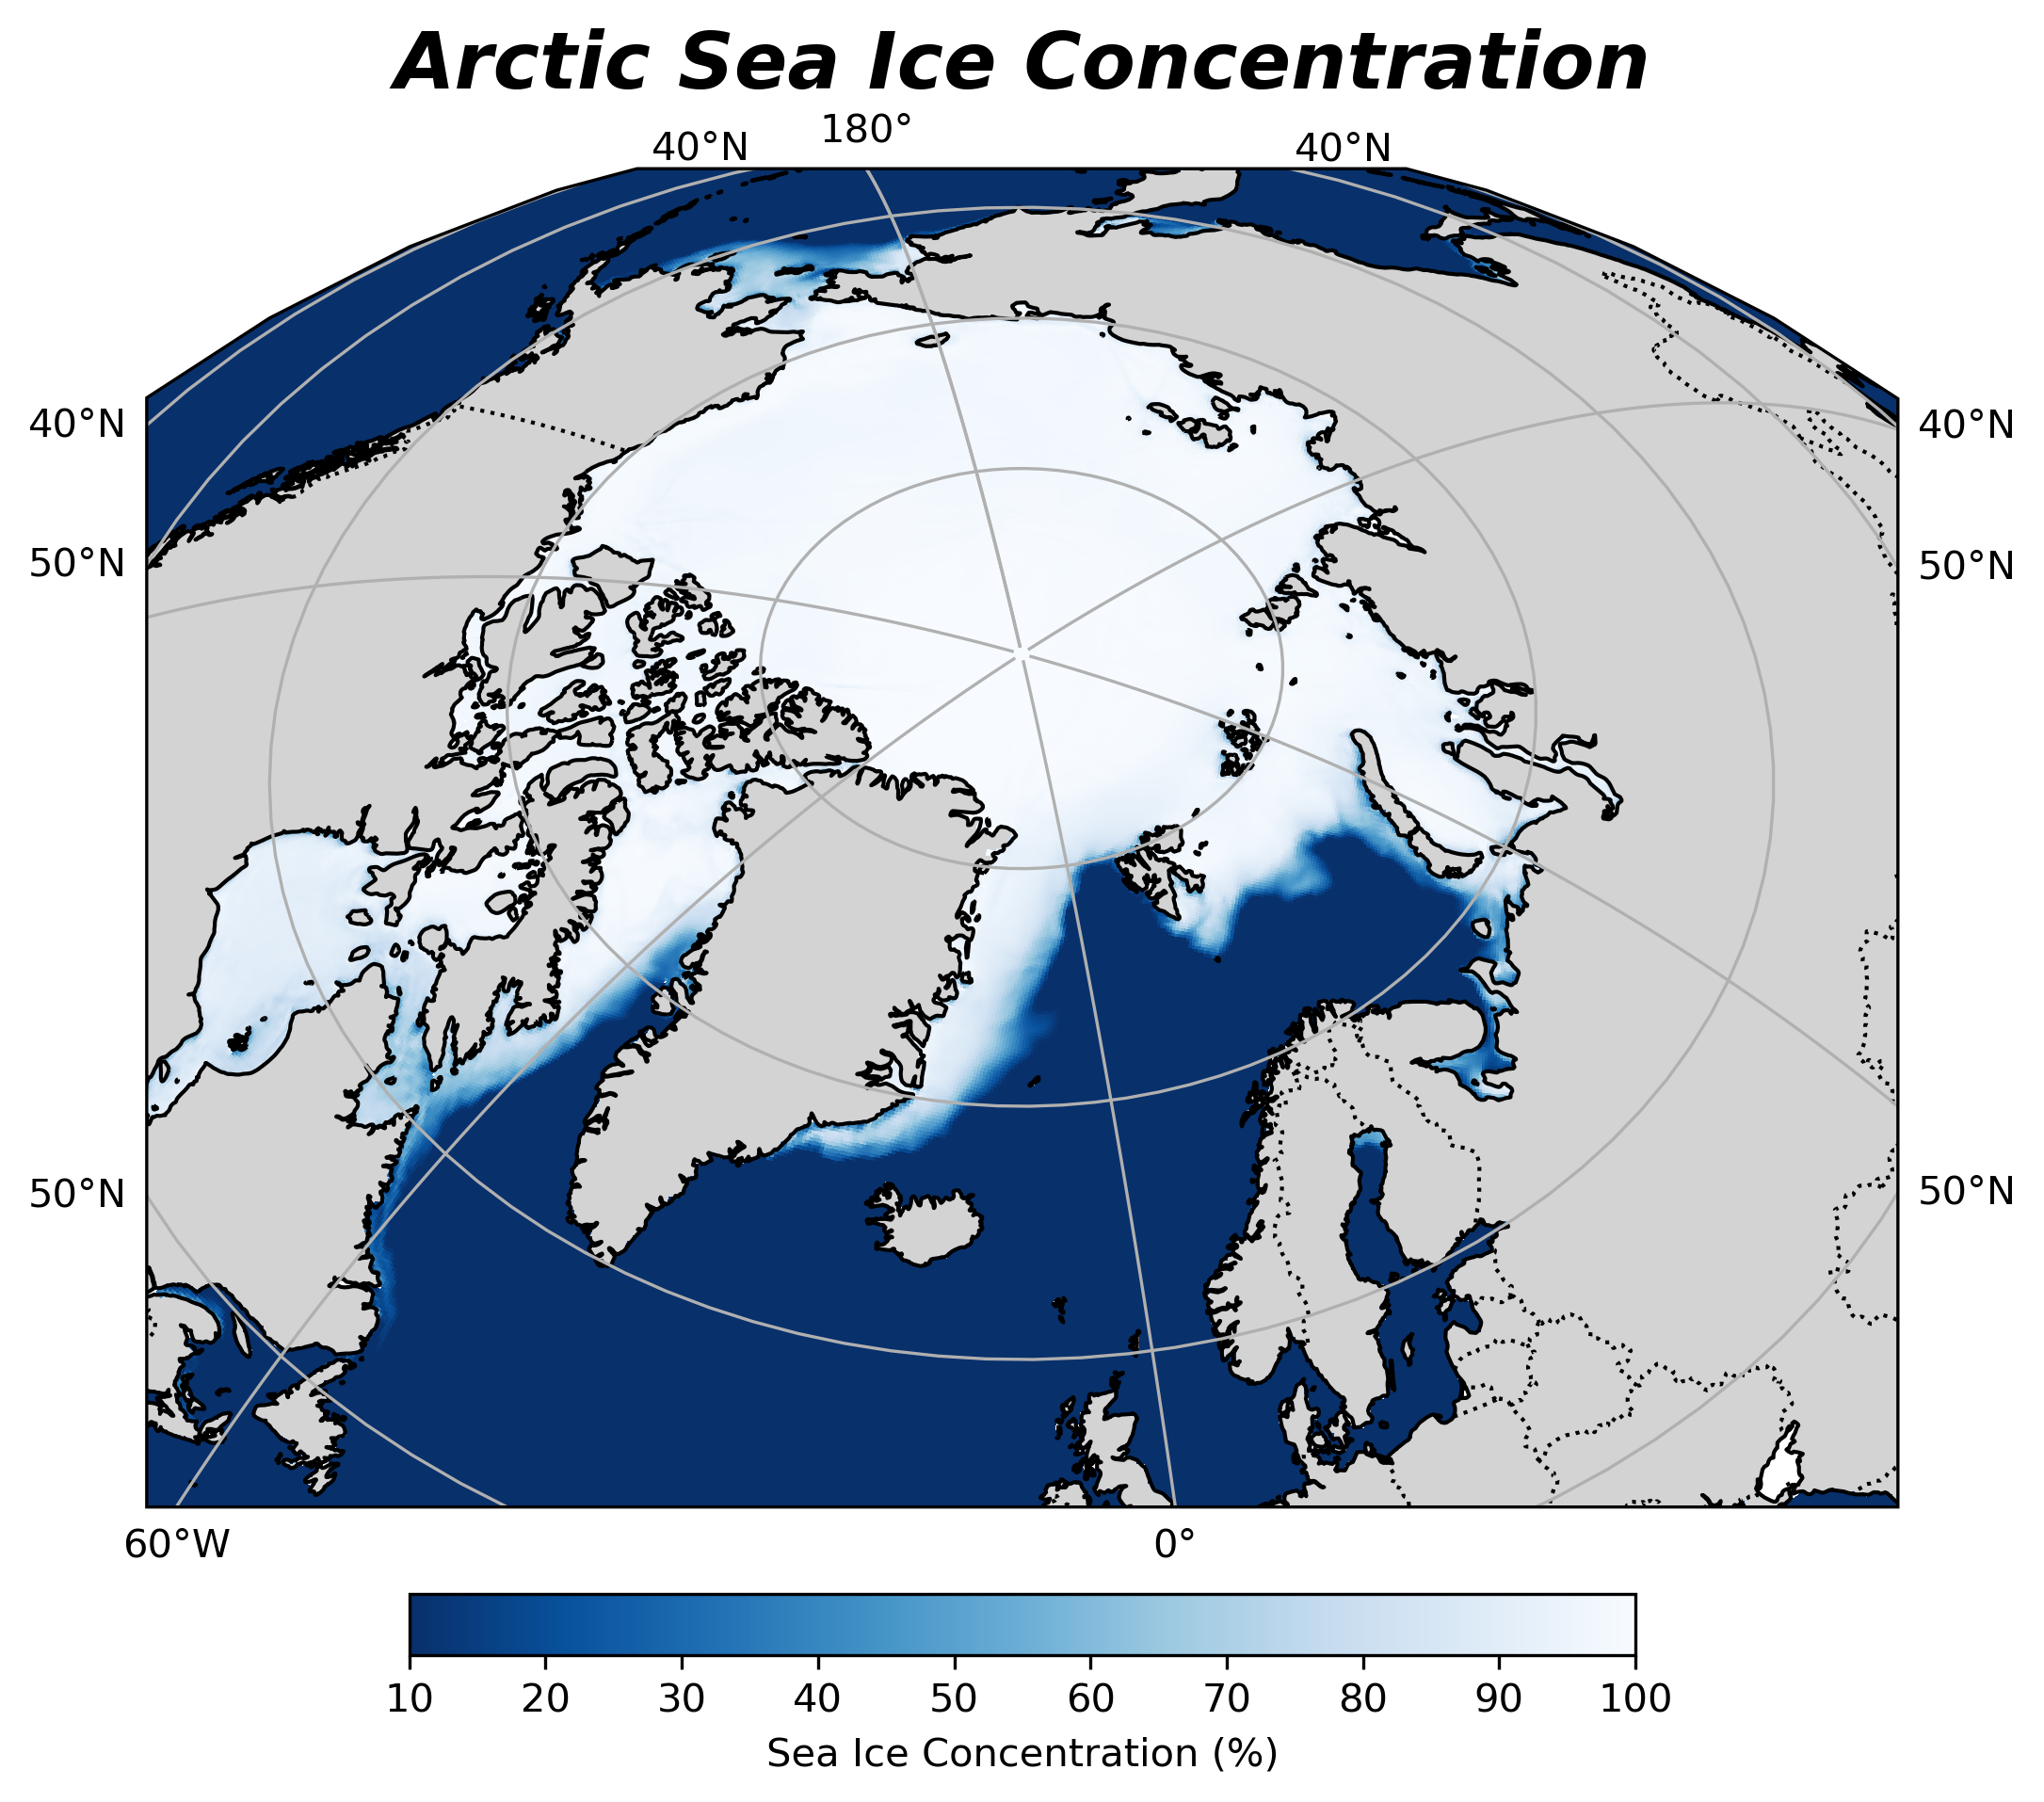

In [12]:
# Create a figure with North Polar projection
plt.figure(figsize=(8, 8), dpi=300)
ax = plt.axes(projection=ccrs.Orthographic(central_longitude=-10,\
                                           central_latitude=50))

# Add geographic features
ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.BORDERS, linewidth=1, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.set_extent([-180, 180, 54, 90], crs=ccrs.PlateCarree())
#ax.set_global() # turn off if dont want show the whole globe

# Plot the SIC data
c = ax.pcolormesh(lons, lats, SIC[11,:,:]*100, transform=ccrs.PlateCarree(), 
                  cmap = 'Blues_r', shading='auto', vmin = 10, vmax = 100)

# Add a colorbar
cb = plt.colorbar(c, ax=ax, orientation='horizontal', shrink=0.7, pad=0.05)
cb.set_label("Sea Ice Concentration (%)")

# Add gridlines
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# Show the plot
plt.title("Arctic Sea Ice Concentration", fontsize =20, fontstyle='italic',fontweight='bold')
plt.show()

In [16]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

def calculate_trend_3d_confidence(data, time_dim=-1, confidence=95):
    """
    ---------------------------------------------------------------------------------------------
    Calculate the linear trend (slope) over time for a 3D dataset and return trends
    significant at the given confidence level.
    
    Parameters:
    -----------
    data (numpy array): A 3D numpy array representing data over time.
    time_dim (int): The index of the time dimension in the data (default is -1, last dimension).
    confidence (float): The confidence level (e.g., 95 for 95% confidence, 99 for 99% confidence).
    
    Returns:
    ------- 
    trend (numpy array): A 2D numpy array (lat, lon) representing the significant slope (trend)
                         for each grid point. Non-significant trends are set to NaN.
    ---------------------------------------------------------------------------------------------
    """
    # Move the time dimension to the last axis if it's not already
    if time_dim != -1:
        data = np.moveaxis(data, time_dim, -1)
    
    # Get the new dimensions of the data
    lat, lon, time = data.shape

    # Convert confidence level to p-value threshold
    p_value_threshold = 1 - confidence / 100.0

    # Create an array of time points (e.g., time indices)
    time_points = np.arange(time)

    # Initialize an array to hold the trend values (slopes) for each lat-lon point
    trend = np.full((lat, lon), np.nan)  # Initialize with NaNs (for non-significant trends)

    # Calculate the trend (slope) for each (lat, lon) point
    for i in range(lat):
        for j in range(lon):
            # Extract the time series for this (lat, lon) point
            y = data[i, j, :]
            
            # Perform linear regression
            slope, intercept, r_value, p_value, std_err = stats.linregress(time_points, y)
            
            # Check if the trend is significant based on the specified confidence level
            if p_value < p_value_threshold:
                trend[i, j] = slope  # Only store the slope if it is significant

    return trend

In [17]:
#Compute the trend of sea ice concentration  for Winter, Summer, Fall

summer_trend = calculate_trend_3d_confidence(SIC_summer_mean, time_dim=0, confidence=90)
winter_trend = calculate_trend_3d_confidence(SIC_winter_mean, time_dim=0, confidence=90)
fall_trend = calculate_trend_3d_confidence(SIC_fall_mean, time_dim=0, confidence=90)
spring_trend = calculate_trend_3d_confidence(SIC_spring_mean, time_dim=0, confidence=90)

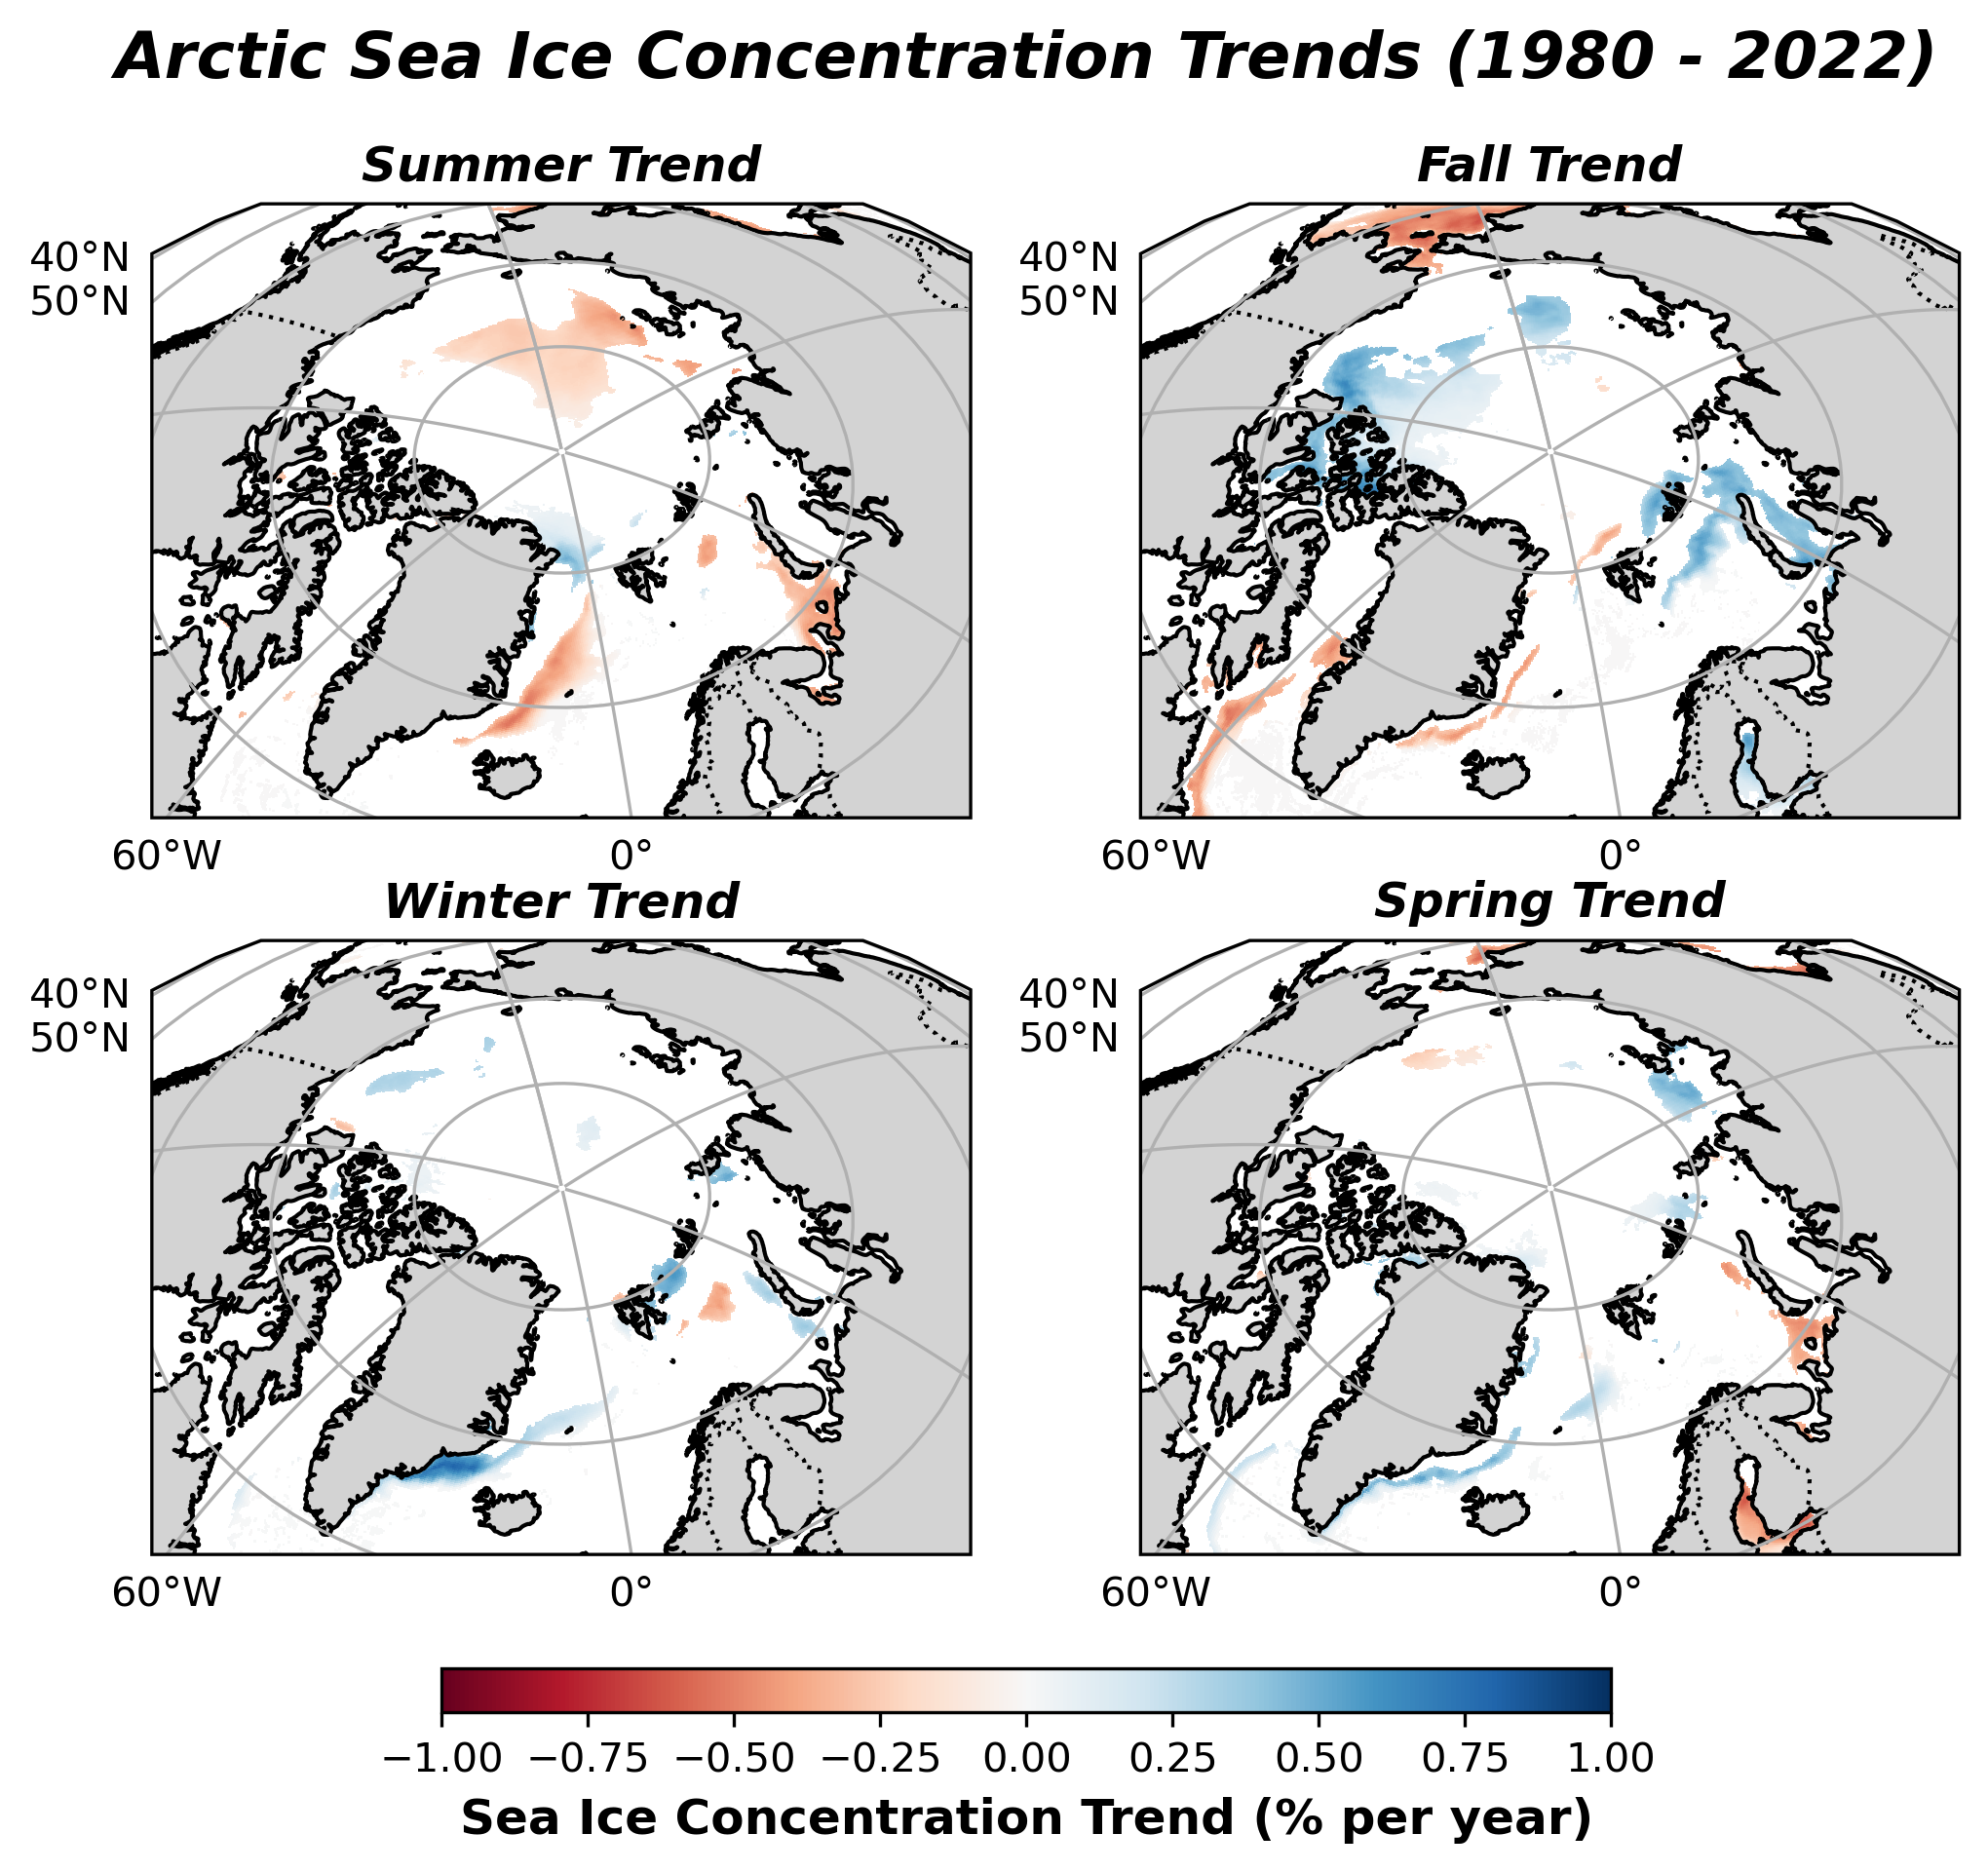

In [45]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Create a 2x2 subplot figure
fig, axs = plt.subplots(2, 2, figsize=(8, 6), subplot_kw={'projection': ccrs.Orthographic(central_longitude=-10, central_latitude=50)}, dpi=300)
fig.suptitle("Arctic Sea Ice Concentration Trends (1980 - 2022)", fontsize=16, fontstyle='italic', fontweight='bold')

# List of trends and titles
trends = [summer_trend, fall_trend, winter_trend, spring_trend]
titles = ["Summer", "Fall", "Winter", "Spring"]

# Loop over subplots
for ax, trend, title in zip(axs.flat, trends, titles):
    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.BORDERS, linewidth=1, linestyle=':')
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())

    # Plot SIC trend
    c = ax.pcolormesh(lons, lats, trend * 100, transform=ccrs.PlateCarree(),
                      cmap='RdBu', shading='auto', vmin=-1, vmax=1)

    # Add title for each subplot
    ax.set_title(f"{title} Trend", fontsize=12, fontweight='bold', style='italic')

    # Add gridlines with latitude and longitude labels
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.top_labels = False
    gl.right_labels = False

# Colorbar
cb_ax = fig.add_axes([0.25, 0.02, 0.5, 0.025])
cbar = fig.colorbar(c, cax=cb_ax, orientation='horizontal')
cbar.set_label("Sea Ice Concentration Trend (% per year)", fontsize=12, fontweight='bold')
plt.show()